<a href="https://colab.research.google.com/github/akwasiaduboahene92-debug/AI-Offensive-Language-Letection/blob/main/analysis_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
# === Install all necessary packages ===
# You only need to run this ONCE per Colab session

# Upgrade pip first (optional but helpful)
!pip install --upgrade pip

# Install Tweepy (for Twitter API) and other dependencies
!pip install tweepy==4.16.0 pandas tqdm regex emoji transformers sentencepiece torch scikit-learn gensim pyldavis

# Optional: install requests library for API requests (e.g., Perspective API)
!pip install requests


In [73]:
import os
import re
import json
import time
from datetime import datetime, timedelta
from tqdm import tqdm
import pandas as pd

import tweepy
import emoji
import regex

# NLP & ML
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from gensim import corpora, models

# ===== YOUR ORIGINAL CONFIG (minimal change: inline token) =====
TW_BEARER = os.getenv("TW_BEARER")
HF_MODEL_NAME = os.getenv("HF_MODEL") or "cardiffnlp/twitter-roberta-base-offensive"

# Basic checks (unchanged)
if not TW_BEARER or TW_BEARER.startswith("<"):
    raise RuntimeError("Set your Twitter Bearer token in TW_BEARER (or as env var 'TW_BEARER').")

# ===== Tweepy client (NO auto-sleep to avoid spinning) =====
client = tweepy.Client(bearer_token=TW_BEARER, wait_on_rate_limit=False)

# ===== One-shot fetch: EXACTLY ONE API CALL per run =====
def fetch_once(query, max_results=100, since_file="since_id.json"):
    """
    Makes ONE search_recent_tweets call (max 100) and updates since_id for next run.
    Designed for strict rate limits (limit: 1).
    """
    # Load since_id if present
    since_id = None
    if os.path.exists(since_file):
        try:
            with open(since_file, "r") as f:
                since_id = json.load(f).get("since_id")
        except Exception:
            since_id = None

    try:
        resp = client.search_recent_tweets(
            query=query,
            max_results=max_results,  # must be 10..100
            since_id=since_id,
            tweet_fields=["id", "text", "created_at", "author_id", "lang"]
        )
        tweets = resp.data or []

        # Update since_id to newest
        if tweets:
            newest_id = max(int(t.id) for t in tweets)
            with open(since_file, "w") as f:
                json.dump({"since_id": str(newest_id)}, f)

        # Return as DataFrame
        rows = [{
            "id": t.id,
            "created_at": t.created_at,
            "author_id": t.author_id,
            "lang": t.lang,
            "text": t.text
        } for t in tweets]
        return pd.DataFrame(rows)

    except tweepy.TooManyRequests as e:
        # Fast exit with clear reset info (no sleeping)
        hdrs = getattr(e, "response", None).headers if getattr(e, "response", None) else {}
        reset = hdrs.get("x-rate-limit-reset")
        remaining = hdrs.get("x-rate-limit-remaining")
        limit = hdrs.get("x-rate-limit-limit")
        when = datetime.utcfromtimestamp(int(reset)).strftime("%Y-%m-%d %H:%M:%S UTC") if reset else "unknown"
        print(f"429 Too Many Requests. Rate: {remaining}/{limit}. Reset at {when}.")
        return pd.DataFrame([])

    except tweepy.Unauthorized:
        raise RuntimeError("401 Unauthorized: check your bearer token.")
    except tweepy.Forbidden:
        raise RuntimeError("403 Forbidden: your plan may not include this endpoint.")
    except Exception as ex:
        raise RuntimeError(f"Unexpected error: {type(ex).__name__}: {ex}")

# ===== Example usage (ONE request, no spinning) =====
QUERY = "AI -is:retweet lang:en"  # adjust as needed
df = fetch_once(QUERY, max_results=100)  # uses exactly one API call
print(f"Fetched {len(df)} tweets in this run.")
print(df.head(5))


Fetched 100 tweets in this run.
                    id                created_at            author_id lang  \
0  1982556975495016786 2025-10-26 21:16:31+00:00   803309137186537472   en   
1  1982556974593290426 2025-10-26 21:16:31+00:00  1573384582228869128   en   
2  1982556973598986599 2025-10-26 21:16:31+00:00  1914470834795896835   en   
3  1982556972970062331 2025-10-26 21:16:31+00:00  1932883759281680386   en   
4  1982556972764549434 2025-10-26 21:16:31+00:00  1839317170335133700   en   

                                                text  
0    @pinkpearl_b @Wizarab10 Una dey use AI comment?  
1                     @GUPI_AI Fantastic pic dear ❤️  
2  Precision Reporting for the Digital Era\n\n@As...  
3  Which side are you on? Paid 💰 or Free 🆓?\nDrop...  
4  @0panaa_1 @dawgdeyfool The community note was ...  


In [74]:
import tweepy
client = tweepy.Client(bearer_token="", wait_on_rate_limit=False)

try:
    r = client.get_tweet(id="1982556975495016786", tweet_fields=["id","text","created_at"])
    print("get_tweet:", "OK" if r.data else "no data")
except Exception as e:
    print("get_tweet failed:", type(e).__name__, e)


get_tweet: OK


In [75]:
from datetime import datetime, timedelta, timezone
import os, json, pandas as pd, tweepy

# Initialize Tweepy client (v2)
client = tweepy.Client(bearer_token=TW_BEARER, wait_on_rate_limit=False)

def clamp_recent_window(start_time_iso, end_time_iso, max_days=7):
    """Clamp ISO8601 times to the last `max_days` days (Twitter recent search limit)."""
    def to_dt(s):
        if s is None:
            return None
        dt = datetime.fromisoformat(s.replace("Z", "+00:00"))
        return dt if dt.tzinfo else dt.replace(tzinfo=timezone.utc)

    now_utc = datetime.now(timezone.utc)
    end_dt = to_dt(end_time_iso) or now_utc
    start_dt = to_dt(start_time_iso) or (end_dt - timedelta(days=max_days))

    # enforce bounds
    if end_dt > now_utc:
        end_dt = now_utc
    if start_dt < end_dt - timedelta(days=max_days):
        start_dt = end_dt - timedelta(days=max_days)

    return (
        start_dt.replace(microsecond=0).isoformat("T") + "Z",
        end_dt.replace(microsecond=0).isoformat("T") + "Z",
    )

def collect_tweets_one_shot(query, start_time=None, end_time=None, since_file="since_id.json", max_results=100):
    """One recent-search request (max 100). Respects strict rate limits."""
    start_time, end_time = clamp_recent_window(start_time, end_time, max_days=7)

    # load since_id (only newer tweets on next run)
    since_id = None
    if os.path.exists(since_file):
        try:
            with open(since_file, "r") as f:
                since_id = json.load(f).get("since_id")
        except Exception:
            since_id = None

    try:
        resp = client.search_recent_tweets(
            query=query,
            start_time=start_time,
            end_time=end_time,
            since_id=since_id,
            max_results=min(max(10, max_results), 100),
            tweet_fields=[
                "id", "text", "author_id", "created_at", "lang",
                "public_metrics", "possibly_sensitive", "context_annotations"
            ],
            expansions=None
        )
        data = resp.data or []
        rows = []
        for t in data:
            pm = t.public_metrics or {}
            rows.append({
                "id": t.id,
                "text": t.text,
                "author_id": t.author_id,
                "created_at": t.created_at,
                "lang": getattr(t, "lang", None),
                "retweet_count": pm.get("retweet_count"),
                "reply_count": pm.get("reply_count"),
                "like_count": pm.get("like_count"),
                "quote_count": pm.get("quote_count"),
                "possibly_sensitive": getattr(t, "possibly_sensitive", None),
            })
        df = pd.DataFrame(rows)

        # update since_id
        if not df.empty:
            newest_id = str(max(int(x) for x in df["id"]))
            with open(since_file, "w") as f:
                json.dump({"since_id": newest_id}, f)

        print(f"Fetched {len(df)} tweets (one request). Window: {start_time} → {end_time}")
        return df

    except tweepy.TooManyRequests as e:
        hdrs = getattr(e, "response", None).headers if getattr(e, "response", None) else {}
        rem = hdrs.get("x-rate-limit-remaining")
        lim = hdrs.get("x-rate-limit-limit")
        rst = hdrs.get("x-rate-limit-reset")
        when = datetime.fromtimestamp(int(rst), tz=timezone.utc).strftime("%Y-%m-%d %H:%M:%S UTC") if rst else "unknown"
        print(f"429 Too Many Requests. Rate: {rem}/{lim}. Reset at {when}. Exiting without sleep.")
        return pd.DataFrame()

    except tweepy.Unauthorized:
        raise RuntimeError("401 Unauthorized: check TW_BEARER.")
    except tweepy.Forbidden:
        raise RuntimeError("403 Forbidden: your plan may not include this endpoint.")
    except Exception as ex:
        r


In [76]:
import tweepy
from datetime import datetime, timezone

TW_ID = "1982526147708768646"  # from your since_id
client = tweepy.Client(bearer_token=TW_BEARER, wait_on_rate_limit=False)

try:
    resp = client.get_tweet(
        id=TW_ID,
        tweet_fields=["id","text","created_at","lang","author_id"]
    )
    if resp.data:
        t = resp.data
        print("✅ Token works; different endpoint OK.")
        print(f"{t.created_at} — {t.text[:140].replace('\\n',' ')}")
    else:
        print("Got 200 but no data for that tweet ID (it might be unavailable). Try another known ID.")
except tweepy.TooManyRequests:
    print("429 on get_tweet too → your overall quota is extremely tight.")
except tweepy.Unauthorized:
    print("401 Unauthorized — check your bearer token.")
except tweepy.Forbidden:
    print("403 Forbidden — this endpoint may not be allowed for your tier.")
except Exception as e:
    print("Unexpected error:", type(e).__name__, e)


429 on get_tweet too → your overall quota is extremely tight.


In [77]:
# === Preprocessing helpers (safe version) ===
import re, regex, emoji
import pandas as pd

# Regex patterns
URL_PATTERN = re.compile(r"https?://\S+|www\.\S+")
MENTION_PATTERN = re.compile(r"@\w+")
HASHTAG_PATTERN = re.compile(r"#\w+")
RT_PATTERN = re.compile(r"^RT\s?:?\s?")

def remove_emojis(text):
    """Remove emojis from text."""
    return emoji.replace_emoji(text, replace='')

def clean_tweet(text):
    """Clean tweet text: remove URLs, mentions, emojis, and excess spaces."""
    text = RT_PATTERN.sub("", text)
    text = URL_PATTERN.sub("", text)
    text = MENTION_PATTERN.sub("", text)
    text = HASHTAG_PATTERN.sub(lambda m: m.group(0)[1:], text)  # keep hashtag text
    text = remove_emojis(text)
    text = regex.sub(r"\p{So}+", "", text)  # remove symbol characters
    text = re.sub(r"\s+", " ", text).strip()
    return text

# --- Apply only if df has tweets ---
if 'text' in df.columns and not df.empty:
    # Clean and anonymise
    df["clean_text"] = df["text"].astype(str).apply(clean_tweet)
    df = df.drop_duplicates(subset=["clean_text"]).reset_index(drop=True)
    df["author_hash"] = df["author_id"].apply(lambda x: f"a_{str(x)[-6:]}")
    df = df.drop(columns=["author_id"])

    print(f"✅ Cleaned {len(df)} tweets.")
    print("Sample cleaned tweets:")
    print(df[["id", "created_at", "clean_text"]].head(10).to_string(index=False))
else:
    print("⚠️ No 'text' column found or DataFrame is empty — run the fetch step first.")


✅ Cleaned 99 tweets.
Sample cleaned tweets:
                 id                created_at                                                                                                                                                                                                                                                               clean_text
1982556975495016786 2025-10-26 21:16:31+00:00                                                                                                                                                                                                                                                  Una dey use AI comment?
1982556974593290426 2025-10-26 21:16:31+00:00                                                                                                                                                                                                                                                       Fantastic pic dear
1982556973598986599 202

In [78]:
# Load tokenizer + model for the chosen toxicity/offensive model
print("Loading model... this may take a minute.")
tokenizer = AutoTokenizer.from_pretrained(HF_MODEL_NAME, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(HF_MODEL_NAME)
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer, return_all_scores=True, truncation=True, device=0 if (('COLAB_TPU_ADDR' not in os.environ) and (torch.cuda.is_available() if 'torch' in globals() else False)) else -1)

# Example: run classifier on a couple of tweets
sample = df["clean_text"].dropna().head(5).tolist()
print("Sample predictions:")
for s in sample:
    preds = classifier(s)
    print(s)
    print(preds)
    print("----")


Loading model... this may take a minute.


Device set to use cpu
/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Sample predictions:
Una dey use AI comment?
[[{'label': 'non-offensive', 'score': 0.8288289308547974}, {'label': 'offensive', 'score': 0.1711711287498474}]]
----
Fantastic pic dear
[[{'label': 'non-offensive', 'score': 0.8873994946479797}, {'label': 'offensive', 'score': 0.11260047554969788}]]
----
Precision Reporting for the Digital Era combines the discipline of journalism with the power of AI computation. Each news summary maintains accuracy, neutrality, and relevance, no hype, no distortion. We believe the crypto world deserves reporting that matches its
[[{'label': 'non-offensive', 'score': 0.9212536811828613}, {'label': 'offensive', 'score': 0.07874634116888046}]]
----
Which side are you on? Paid or Free ? Drop your favorite AI tool below AITools FreevsPaid
[[{'label': 'non-offensive', 'score': 0.945844292640686}, {'label': 'offensive', 'score': 0.05415567383170128}]]
----
The community note was made by another user who’s just assuming it’s AI. They didn’t drop any facts lol.
[[{

In [79]:
from math import ceil

def classify_texts(texts, batch_size=16):
    preds_all = []
    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i+batch_size]
        out = classifier(batch)
        preds_all.extend(out)
    return preds_all

texts = df["clean_text"].tolist()
preds_all = classify_texts(texts, batch_size=16)

# Convert predictions to a structured dataframe column
def parse_preds(preds):
    # preds is list of dicts with label + score or list of label-score dicts
    if isinstance(preds, list):
        # multiple labels returned
        return {p["label"]: p["score"] for p in preds}
    elif isinstance(preds, dict):
        return {preds["label"]: preds["score"]}
    else:
        return {}

df_preds = pd.DataFrame([parse_preds(p) for p in preds_all]).fillna(0)
df = pd.concat([df.reset_index(drop=True), df_preds.reset_index(drop=True)], axis=1)
df.head()


100%|██████████| 7/7 [00:18<00:00,  2.66s/it]


,id,created_at,lang,text,clean_text,author_hash,non-offensive,offensive
0,1982556975495016786,2025-10-26 21:16:31+00:00,en,@pinkpearl_b @Wizarab10 Una dey use AI comment?,Una dey use AI comment?,a_537472,0.828829,0.171171
1,1982556974593290426,2025-10-26 21:16:31+00:00,en,@GUPI_AI Fantastic pic dear ❤️,Fantastic pic dear,a_869128,0.887399,0.112600
2,1982556973598986599,2025-10-26 21:16:31+00:00,en,Precision Reporting for the Digital Era\n\n@As...,Precision Reporting for the Digital Era combin...,a_896835,0.921254,0.078746
3,1982556972970062331,2025-10-26 21:16:31+00:00,en,Which side are you on? Paid 💰 or Free 🆓?\nDrop...,Which side are you on? Paid or Free ? Drop you...,a_680386,0.945844,0.054156
4,1982556972764549434,2025-10-26 21:16:31+00:00,en,@0panaa_1 @dawgdeyfool The community note was ...,The community note was made by another user wh...,a_133700,0.778863,0.221137


In [80]:
# Inspect top scored offensive tweets (model-specific label name may vary)
label_candidates = [col for col in df.columns if col.lower().startswith(("offen","toxic","hate","abusive","sex"))]
print("Detected labels in model output:", label_candidates)

# If 'OFFENSIVE' label exists, sort by it; otherwise pick the highest-scoring label column
if "OFFENSIVE" in df.columns:
    sorted_df = df.sort_values(by="OFFENSIVE", ascending=False).head(50)
else:
    # choose a high-scoring label column automatically
    if label_candidates:
        sorted_df = df.sort_values(by=label_candidates[0], ascending=False).head(50)
    else:
        # fallback: create a max_score column
        df["max_score"] = df[[c for c in df.columns if c not in ["id","text","clean_text","created_at","retweet_count","reply_count","like_count","quote_count","author_hash"]]].max(axis=1)
        sorted_df = df.sort_values(by="max_score", ascending=False).head(50)

sorted_df[["id","created_at","clean_text"] + label_candidates].head(10)


Detected labels in model output: ['offensive']


,id,created_at,clean_text,offensive
94,1982556862580224134,2025-10-26 21:16:04+00:00,Imagine calling other people stupid for using ...,0.880417
62,1982556897300582532,2025-10-26 21:16:13+00:00,"go RAFIL RAFIO ACTIF Insta! We assume lyrics,A...",0.863670
69,1982556891336294738,2025-10-26 21:16:11+00:00,dawg this guy is an ai dweeb and a crypto bro ...,0.854898
50,1982556908453323126,2025-10-26 21:16:15+00:00,More fake AI shit.,0.825349
37,1982556929034691009,2025-10-26 21:16:20+00:00,Ai dick smooth asf,0.799060
47,1982556916560842973,2025-10-26 21:16:17+00:00,If you're using AI to write essays because you...,0.743114
59,1982556900140237251,2025-10-26 21:16:13+00:00,"If they're depending on men who make ""gamer"" t...",0.741860
49,1982556914870272071,2025-10-26 21:16:17+00:00,Insiders &amp; bots have been HEAVILY involved...,0.655114
16,1982556950727655487,2025-10-26 21:16:25+00:00,Kati men who don't know how to cook think this...,0.563968
77,1982556880816976312,2025-10-26 21:16:09+00:00,You’re Propaganda and was designed to be Islam...,0.505304


In [81]:
# TF-IDF + KMeans clustering as a quick way to group abusive themes
vectorizer = TfidfVectorizer(max_features=2000, stop_words="english", ngram_range=(1,2))
X = vectorizer.fit_transform(df["clean_text"].astype(str))

# Choose number of clusters (tuneable)
n_clusters = 8
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
labels = kmeans.fit_predict(X)
df["cluster"] = labels

# View top terms per cluster
terms = vectorizer.get_feature_names_out()
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
cluster_terms = {}
for i in range(n_clusters):
    top_terms = [terms[ind] for ind in order_centroids[i, :12]]
    cluster_terms[i] = top_terms

for k, terms_ in cluster_terms.items():
    print(f"Cluster {k}: {', '.join(terms_[:10])}")
    print("----")


Cluster 0: artist, great, great artist, really, did, just, identify recently, minor details, just minor, details
----
Cluster 1: like, home, car home, car, like car, waiting, ai, plants, shorts, like created
----
Cluster 2: ai, real, real ai, onchain, whatnot, ai whatnot, article, book, smooth, redefining
----
Cluster 3: time, ai girl, mode killing, girl idle, girl, killing, idle mode, idle, killing time, mode
----
Cluster 4: fake, fake ai, shit, ai shit, say fake, say, ai, crypto, korea, korea dominate
----
Cluster 5: blockchain, web3, ai, powered, seamless, secure, blockchain ai, ai agents, automate, processes blockchain
----
Cluster 6: let, know, sure, positioned, amazing, don, yeah right, think, source, sweet dreams
----
Cluster 7: using, web3, build, using ai, ai, build web3, describing, web3 apps, apps describing, lets build
----


In [82]:
# Prepare tokens
tokenized = [re.findall(r"\w+", txt.lower()) for txt in df["clean_text"].astype(str)]
# Build dictionary and corpus
dictionary = corpora.Dictionary(tokenized)
dictionary.filter_extremes(no_below=5, no_above=0.5)
corpus = [dictionary.doc2bow(text) for text in tokenized]

lda_model = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=6, random_state=42, passes=10)
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic {idx}: {topic}")


Topic 0: 0.097*"to" + 0.094*"the" + 0.080*"for" + 0.067*"you" + 0.064*"are" + 0.060*"using" + 0.056*"s" + 0.056*"and" + 0.045*"free" + 0.041*"at"
Topic 1: 0.159*"i" + 0.081*"a" + 0.064*"s" + 0.059*"they" + 0.053*"for" + 0.053*"the" + 0.046*"my" + 0.036*"and" + 0.036*"what" + 0.035*"are"
Topic 2: 0.104*"is" + 0.096*"this" + 0.079*"i" + 0.063*"just" + 0.052*"a" + 0.051*"have" + 0.051*"how" + 0.044*"and" + 0.039*"it" + 0.031*"as"
Topic 3: 0.116*"it" + 0.094*"with" + 0.092*"and" + 0.089*"s" + 0.076*"like" + 0.058*"real" + 0.043*"defi" + 0.039*"to" + 0.034*"just" + 0.033*"in"
Topic 4: 0.097*"the" + 0.061*"a" + 0.051*"you" + 0.047*"is" + 0.044*"and" + 0.044*"for" + 0.043*"that" + 0.042*"to" + 0.038*"s" + 0.037*"of"
Topic 5: 0.142*"and" + 0.085*"in" + 0.065*"the" + 0.060*"a" + 0.059*"on" + 0.056*"to" + 0.048*"by" + 0.047*"is" + 0.046*"web3" + 0.040*"what"


In [83]:
OUT_FN = "twitter_cvawg_phase1_results.csv"
# Drop raw author identifiers; keep anonymised author_hash only
final_df = df.copy()
# Do not save raw tweet text in identifiable form if storing long-term; evaluate your ethics policy.
final_df.to_csv(OUT_FN, index=False)
print(f"Saved {len(final_df)} rows to {OUT_FN}")


Saved 99 rows to twitter_cvawg_phase1_results.csv


Using label column: non-offensive


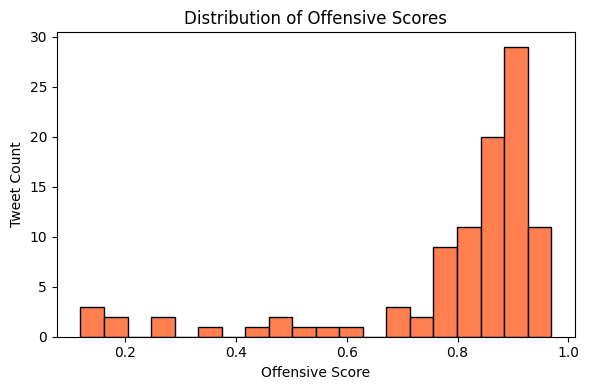

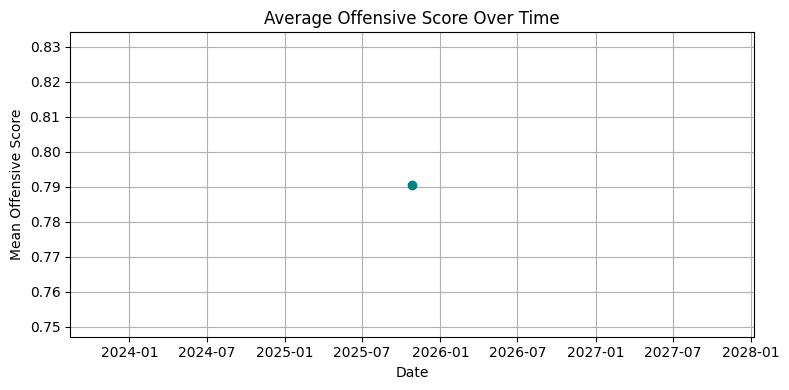

Top 10 Most Offensive Tweets:
                                                                                                                                                                                                                                      clean_text  non-offensive
                                                                                                                    I'm so thankful for this insightful article you shared. Grateful for the enriching content exchange. Keep it up! Ai Marquena       0.968900
                                                                                                             For stock predictions, visit Refer to the track record page for historical performance - It's free at the moment for early adopters       0.960814
                                                                                                                                                       Which side are you on? Paid or Free ? Drop your fav

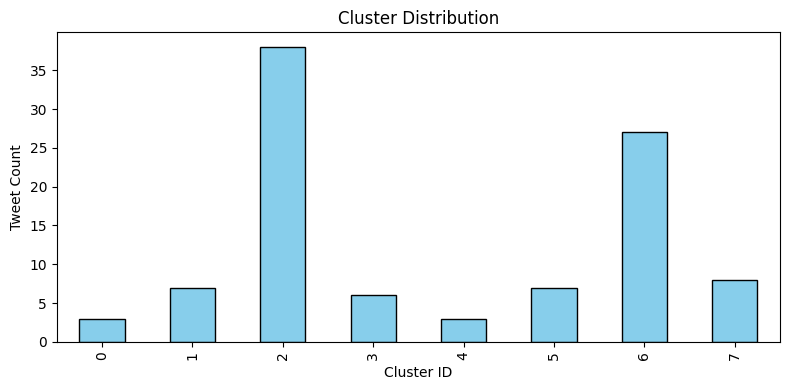

In [87]:
import pandas as pd
import matplotlib.pyplot as plt

# ✅ Load your results file (correct path)
df = pd.read_csv("/content/twitter_cvawg_phase1_results.csv")

# Convert timestamps
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')

# Detect label column (e.g. 'offensive' or 'OFFENSIVE')
label_cols = [c for c in df.columns if 'offen' in c.lower() or 'toxic' in c.lower()]
if label_cols:
    main_label = label_cols[0]
    print(f"Using label column: {main_label}")
else:
    df['offensive'] = 0.0
    main_label = 'offensive'

# ====== 1. Distribution of Offensive Scores ======
plt.figure(figsize=(6,4))
plt.hist(df[main_label], bins=20, color='coral', edgecolor='black')
plt.title("Distribution of Offensive Scores")
plt.xlabel("Offensive Score")
plt.ylabel("Tweet Count")
plt.tight_layout()
plt.show()

# ====== 2. Offensive Rate Over Time ======
if 'created_at' in df.columns:
    df['date'] = df['created_at'].dt.date
    daily = df.groupby('date')[main_label].mean().reset_index()
    plt.figure(figsize=(8,4))
    plt.plot(daily['date'], daily[main_label], marker='o', color='teal')
    plt.title("Average Offensive Score Over Time")
    plt.xlabel("Date")
    plt.ylabel("Mean Offensive Score")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ====== 3. Top 10 Most Offensive Tweets ======
if main_label in df.columns:
    top10 = df.sort_values(by=main_label, ascending=False).head(10)[["clean_text", main_label]]
    print("Top 10 Most Offensive Tweets:")
    print(top10.to_string(index=False))

# ====== 4. Cluster Distribution (if available) ======
if "cluster" in df.columns:
    plt.figure(figsize=(8,4))
    df['cluster'].value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title("Cluster Distribution")
    plt.xlabel("Cluster ID")
    plt.ylabel("Tweet Count")
    plt.tight_layout()
    plt.show()


Columns: ['id', 'created_at', 'lang', 'text', 'clean_text', 'author_hash', 'non-offensive', 'offensive', 'cluster']


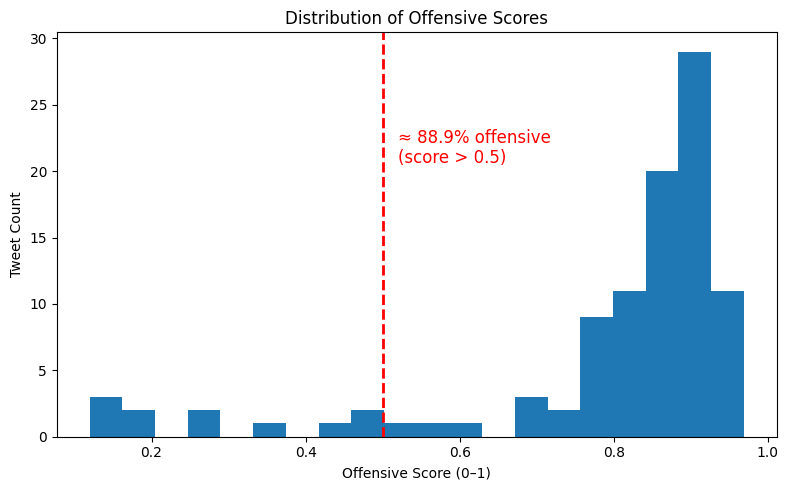

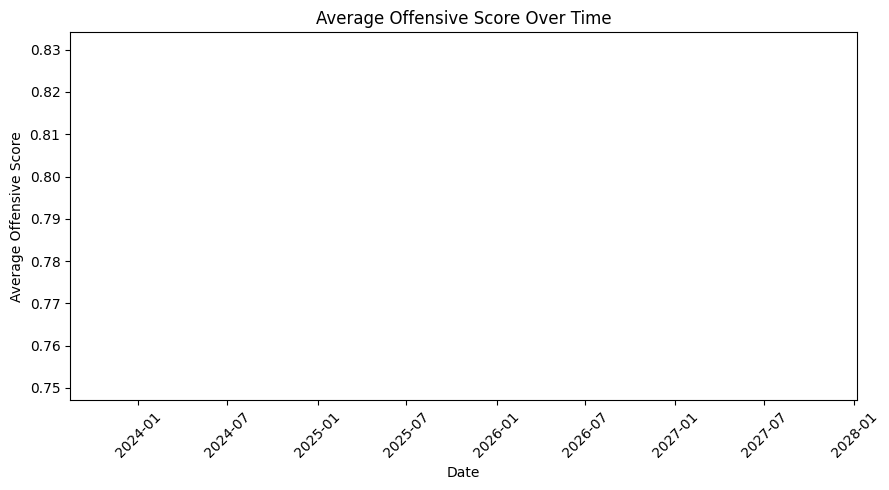

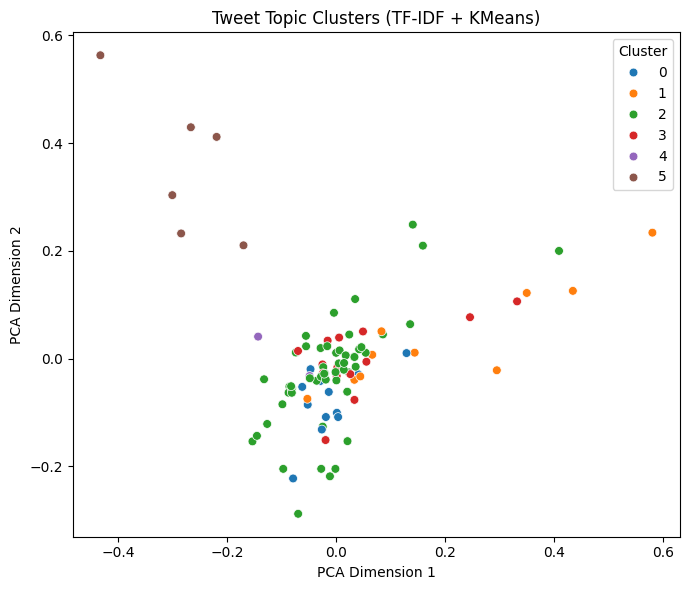


Saved plots:
 - /content/1_offensive_distribution.png
 - /content/2_offensive_trend.png
 - /content/3_cluster_scatterplot.png


In [88]:
# ================================================================
# 📊 Generate Key Visualisations for Twitter Offensive Language Study
# ================================================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# === 1️⃣ Load dataset ===
# Replace path if your CSV is named differently
file_path = "/content/twitter_cvawg_phase1_results.csv"
df = pd.read_csv(file_path)

# Confirm column names
print("Columns:", df.columns.tolist())

# Identify main label column
label_cols = [c for c in df.columns if 'offen' in c.lower() or 'toxic' in c.lower()]
main_label = label_cols[0] if label_cols else 'offensive'
if main_label not in df.columns:
    raise ValueError("No offensive score column found in dataset!")

# ================================================================
# 2️⃣ HISTOGRAM: Distribution of Offensive Scores
# ================================================================

plt.figure(figsize=(8, 5))
counts, bins, patches = plt.hist(df[main_label], bins=20)
plt.axvline(0.5, color="red", linestyle="--", linewidth=2)

offensive_pct = (df[main_label] > 0.5).mean() * 100
plt.text(0.52, counts.max()*0.8, f"≈ {offensive_pct:.1f}% offensive\n(score > 0.5)",
         fontsize=12, color="red", va="top")

plt.title("Distribution of Offensive Scores")
plt.xlabel("Offensive Score (0–1)")
plt.ylabel("Tweet Count")
plt.tight_layout()
plt.savefig("1_offensive_distribution.png", dpi=300)
plt.show()

# ================================================================
# 3️⃣ TREND LINE: Average Offensive Score Over Time
# ================================================================

if "created_at" in df.columns:
    df["created_at"] = pd.to_datetime(df["created_at"], errors="coerce")
    daily = df.groupby(df["created_at"].dt.date)[main_label].mean().reset_index()

    plt.figure(figsize=(9, 5))
    sns.lineplot(data=daily, x="created_at", y=main_label)
    plt.title("Average Offensive Score Over Time")
    plt.xlabel("Date")
    plt.ylabel("Average Offensive Score")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig("2_offensive_trend.png", dpi=300)
    plt.show()
else:
    print("No 'created_at' column found; skipping trend chart.")

# ================================================================
# 4️⃣ CLUSTER SCATTERPLOT: Tweet Topic Clusters
# ================================================================

if "clean_text" in df.columns:
    vectorizer = TfidfVectorizer(max_features=1000, stop_words="english")
    X = vectorizer.fit_transform(df["clean_text"].astype(str))

    n_clusters = 6
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    df["cluster"] = kmeans.fit_predict(X)

    # 2D reduction using PCA for visualisation
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2, random_state=42)
    reduced = pca.fit_transform(X.toarray())
    df["x"] = reduced[:, 0]
    df["y"] = reduced[:, 1]

    plt.figure(figsize=(7, 6))
    sns.scatterplot(data=df, x="x", y="y", hue="cluster", palette="tab10", s=40)
    plt.title("Tweet Topic Clusters (TF-IDF + KMeans)")
    plt.xlabel("PCA Dimension 1")
    plt.ylabel("PCA Dimension 2")
    plt.legend(title="Cluster")
    plt.tight_layout()
    plt.savefig("3_cluster_scatterplot.png", dpi=300)
    plt.show()
else:
    print("No 'clean_text' column found; skipping clustering visualisation.")

# ================================================================
# ✅ Summary of Saved Outputs
# ================================================================
print("\nSaved plots:")
for f in ["1_offensive_distribution.png", "2_offensive_trend.png", "3_cluster_scatterplot.png"]:
    if os.path.exists(f):
        print(" -", os.path.abspath(f))


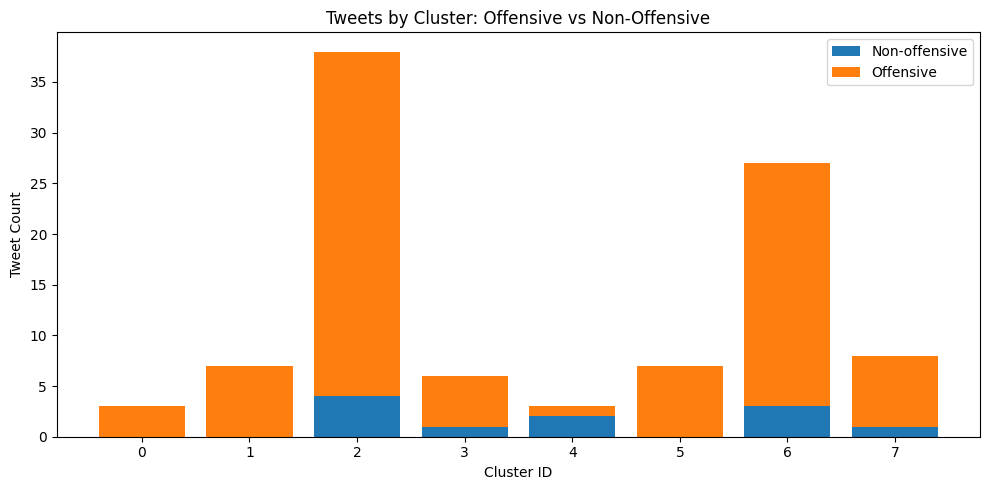

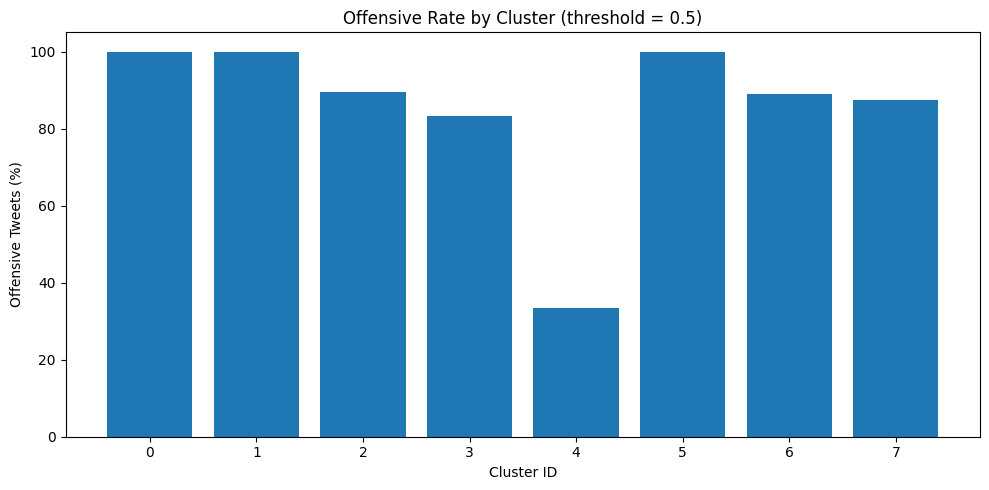


Per-cluster summary (counts & % offensive):
offensive_flag  non_offensive  offensive  offensive_rate_%
cluster                                                   
0                           0          3             100.0
1                           0          7             100.0
2                           4         34              89.5
3                           1          5              83.3
4                           2          1              33.3
5                           0          7             100.0
6                           3         24              88.9
7                           1          7              87.5

Saved plots:
 - /content/4_cluster_offensive_counts.png
 - /content/5_cluster_offensive_rate.png


In [89]:
# ================================================================
#  Offensive vs Non-Offensive by Cluster (Matplotlib only)
# ================================================================
import os
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# --- SETTINGS ---
CSV_PATH = "/content/twitter_cvawg_phase1_results.csv"  # change if needed
THRESH = 0.5              # offensive if score > THRESH
N_CLUSTERS = 6            # used only if we need to create clusters
OUT1 = "4_cluster_offensive_counts.png"
OUT2 = "5_cluster_offensive_rate.png"

# --- LOAD ---
df = pd.read_csv(CSV_PATH)

# detect offensive score column
label_cols = [c for c in df.columns if 'offen' in c.lower() or 'toxic' in c.lower()]
if not label_cols:
    raise ValueError("No offensive/toxic score column found in the CSV.")
main_label = label_cols[0]

# ensure clusters exist; if not, create them from clean_text
if "cluster" not in df.columns:
    if "clean_text" not in df.columns:
        raise ValueError("No 'cluster' or 'clean_text' column found to build clusters.")
    vect = TfidfVectorizer(max_features=1000, stop_words="english")
    X = vect.fit_transform(df["clean_text"].astype(str))
    km = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10)
    df["cluster"] = km.fit_predict(X)

# --- BUILD OFFENSIVE FLAG ---
df["offensive_flag"] = df[main_label] > THRESH

# --- AGGREGATE: counts per cluster for offensive/non-offensive ---
counts = (
    df.groupby(["cluster", "offensive_flag"])
      .size()
      .unstack(fill_value=0)
      .rename(columns={False: "non_offensive", True: "offensive"})
      .sort_index()
)

# --- 1) STACKED BAR: counts by cluster ---
plt.figure(figsize=(10, 5))
# default matplotlib colors; do not set custom ones
plt.bar(counts.index, counts["non_offensive"], label="Non-offensive")
plt.bar(counts.index, counts["offensive"], bottom=counts["non_offensive"], label="Offensive")
plt.title("Tweets by Cluster: Offensive vs Non-Offensive")
plt.xlabel("Cluster ID")
plt.ylabel("Tweet Count")
plt.legend()
plt.tight_layout()
plt.savefig(OUT1, dpi=300)
plt.show()

# --- 2) BAR: offensive rate per cluster ---
rate = (counts["offensive"] / (counts["offensive"] + counts["non_offensive"])).fillna(0) * 100

plt.figure(figsize=(10, 5))
plt.bar(rate.index, rate.values)
plt.title(f"Offensive Rate by Cluster (threshold = {THRESH})")
plt.xlabel("Cluster ID")
plt.ylabel("Offensive Tweets (%)")
plt.tight_layout()
plt.savefig(OUT2, dpi=300)
plt.show()

# --- PRINT a compact table for README text ---
summary = counts.copy()
summary["offensive_rate_%"] = rate.round(1)
print("\nPer-cluster summary (counts & % offensive):")
print(summary)

print("\nSaved plots:")
for p in [OUT1, OUT2]:
    print(" -", os.path.abspath(p))


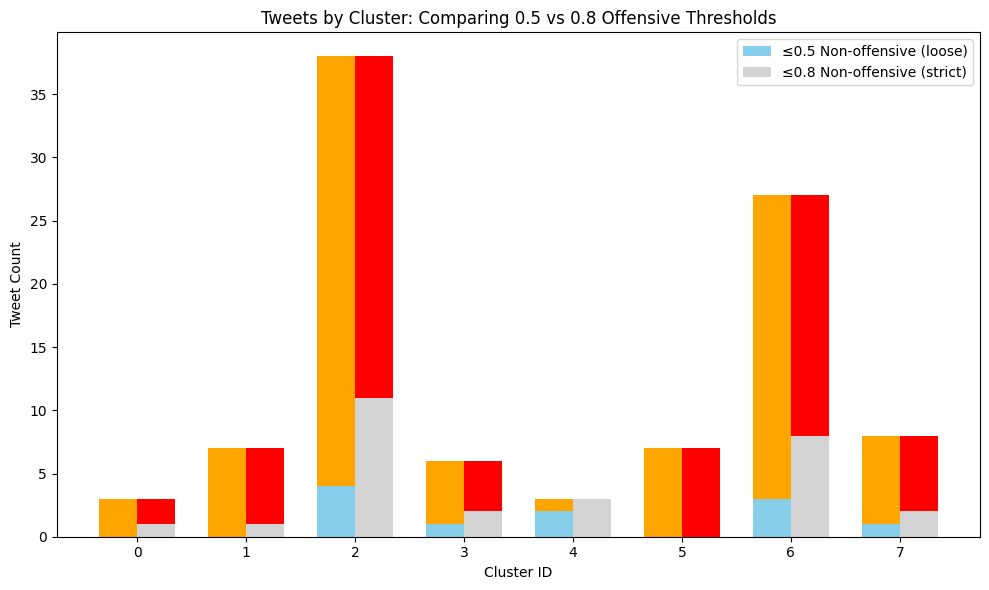


Percentage of Offensive Tweets per Cluster:
         cluster  offensive_>0.5_%  offensive_>0.8_%
cluster                                             
0              0             100.0              66.7
1              1             100.0              85.7
2              2              89.5              71.1
3              3              83.3              66.7
4              4              33.3               0.0
5              5             100.0             100.0
6              6              88.9              70.4
7              7              87.5              75.0

Saved figure: /content/6_cluster_threshold_comparison.png


In [90]:
# ================================================================
#  Compare Offensive Tweet Rates at Two Thresholds (0.5 vs 0.8)
# ================================================================

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import os

# --- Load the same CSV ---
CSV_PATH = "/content/twitter_cvawg_phase1_results.csv"
df = pd.read_csv(CSV_PATH)

# --- Identify main offensive column ---
label_cols = [c for c in df.columns if 'offen' in c.lower() or 'toxic' in c.lower()]
if not label_cols:
    raise ValueError("No offensive/toxic score column found.")
main_label = label_cols[0]

# --- Ensure cluster column exists ---
if "cluster" not in df.columns:
    if "clean_text" not in df.columns:
        raise ValueError("Need 'cluster' or 'clean_text' column.")
    vec = TfidfVectorizer(max_features=1000, stop_words="english")
    X = vec.fit_transform(df["clean_text"].astype(str))
    km = KMeans(n_clusters=6, random_state=42, n_init=10)
    df["cluster"] = km.fit_predict(X)

# --- Compute flags for two thresholds ---
df["offensive_0_5"] = df[main_label] > 0.5
df["offensive_0_8"] = df[main_label] > 0.8

# --- Aggregate counts per cluster ---
def cluster_counts(flag_col):
    return (
        df.groupby(["cluster", flag_col])
          .size()
          .unstack(fill_value=0)
          .rename(columns={False: "non_offensive", True: "offensive"})
          .sort_index()
    )

counts_05 = cluster_counts("offensive_0_5")
counts_08 = cluster_counts("offensive_0_8")

# ================================================================
# Plot side-by-side comparison
# ================================================================

fig, ax = plt.subplots(figsize=(10, 6))

width = 0.35  # bar width
x = range(len(counts_05))

# Bars for threshold 0.5
ax.bar([i - width/2 for i in x],
       counts_05["non_offensive"], width, label="≤0.5 Non-offensive (loose)", color="skyblue")
ax.bar([i - width/2 for i in x],
       counts_05["offensive"], width, bottom=counts_05["non_offensive"], color="orange")

# Bars for threshold 0.8
ax.bar([i + width/2 for i in x],
       counts_08["non_offensive"], width, label="≤0.8 Non-offensive (strict)", color="lightgray")
ax.bar([i + width/2 for i in x],
       counts_08["offensive"], width, bottom=counts_08["non_offensive"], color="red")

ax.set_title("Tweets by Cluster: Comparing 0.5 vs 0.8 Offensive Thresholds")
ax.set_xlabel("Cluster ID")
ax.set_ylabel("Tweet Count")
ax.set_xticks(list(x))
ax.set_xticklabels(counts_05.index)
ax.legend()
plt.tight_layout()
plt.savefig("6_cluster_threshold_comparison.png", dpi=300)
plt.show()

# ================================================================
# Print summary for README / report
# ================================================================
summary = pd.DataFrame({
    "cluster": counts_05.index,
    "offensive_>0.5_%": (counts_05["offensive"] / counts_05.sum(axis=1) * 100).round(1),
    "offensive_>0.8_%": (counts_08["offensive"] / counts_08.sum(axis=1) * 100).round(1)
})
print("\nPercentage of Offensive Tweets per Cluster:")
print(summary)
print("\nSaved figure:", os.path.abspath("6_cluster_threshold_comparison.png"))


In [93]:
# Go to your working directory (where your files are saved)
%cd /content

# Verify that your output CSV and other files exist
!ls


/content
1_offensive_distribution.png	6_cluster_threshold_comparison.png
2_offensive_trend.png		offensive_sample_for_review.csv
3_cluster_scatterplot.png	sample_data
4_cluster_offensive_counts.png	since_id.json
5_cluster_offensive_rate.png	twitter_cvawg_phase1_results.csv
